In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

In [5]:
# Cargar el CSV
archivo_csv = os.path.join('..', '..', 'data', 'fact_licitacion-2007_2023-full.csv')
df_csv = pd.read_csv(archivo_csv, encoding="ISO-8859-1", delimiter=",")

In [6]:
df = df_csv.copy()

In [7]:
# Convertir la fecha a tipo datetime
df['id_fecha'] = pd.to_datetime(df['id_fecha'], format='%Y%m%d')
# 1. Crear características de fecha
df['mes'] = df['id_fecha'].dt.month
df['año'] = df['id_fecha'].dt.year

In [8]:
utilizar_solo_añomes = False
nombre_columna_objetivo = 'monto_adjudicado_usd'
categorical_features = ['id_producto']

if utilizar_solo_añomes:
    columnas_x = ['año', 'mes'] + categorical_features
    numeric_features = ['año', 'mes']
else:
    columnas_x = ['id_fecha']  + categorical_features
    numeric_features = ['id_fecha']

columnas_utilizadas = columnas_x + [nombre_columna_objetivo]


In [9]:
df = df.query(nombre_columna_objetivo + ' >= 0')

In [10]:
def filtrar_por_desviacion_estandar(df, factor=1):
    global nombre_columna_objetivo
    # Calcular la media y la desviación estándar para cada id_producto
    grouped_stats = df.groupby('id_producto')[nombre_columna_objetivo].agg(['mean', 'std', 'count']).reset_index()

    # Calcular los límites inferior y superior para cada id_producto
    grouped_stats['lower_limit'] = grouped_stats['mean'] - factor * grouped_stats['std']
    grouped_stats['upper_limit'] = grouped_stats['mean'] + factor * grouped_stats['std']

    # Fusionar los límites con el DataFrame original
    df_merged = pd.merge(df, grouped_stats[['id_producto', 'lower_limit', 'upper_limit', 'count']], on='id_producto')

    # quito los productos con pocos registros
    meses = ((2022 - 2007) * 12) / 2
    df_merged = df_merged.query('count > ' + str(meses))

    # Filtrar los registros que están dentro del rango definido por los límites
    df_filtered = df_merged[(df_merged[nombre_columna_objetivo] >= df_merged['lower_limit']) & 
                            (df_merged[nombre_columna_objetivo] <= df_merged['upper_limit'])]

    return df_filtered

In [11]:
df = filtrar_por_desviacion_estandar(df[columnas_utilizadas])

In [12]:
print(df.shape)

(11681065, 6)


{'whiskers': [<matplotlib.lines.Line2D at 0x153e1b432e0>,
 'caps': [<matplotlib.lines.Line2D at 0x153912d7070>,
 'boxes': [<matplotlib.lines.Line2D at 0x153e1b43040>],
 'medians': [<matplotlib.lines.Line2D at 0x153e1b43760>],
 'fliers': [<matplotlib.lines.Line2D at 0x153e1b43a00>],
 'means': []}

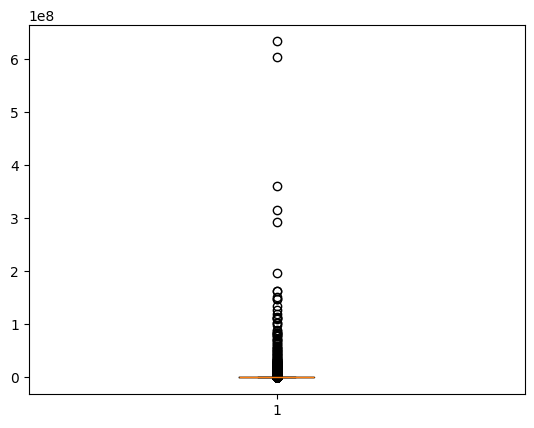

In [13]:
plt.boxplot(df[nombre_columna_objetivo])

In [14]:
# Calcula el primer y tercer cuartil (Q1 y Q3) de la columna 'cantidad_adjudicada'
Q1 = df[nombre_columna_objetivo].quantile(0.25)
Q3 = df[nombre_columna_objetivo].quantile(0.75)

# Calcula el rango intercuartil (IQR)
IQR = Q3 - Q1

# Define un factor multiplicativo para ajustar el umbral (por ejemplo, 1.5 veces el IQR)
factor_umbral = 1.5

# Calcula el valor umbral
umbral = Q3 + factor_umbral * IQR


# Crea una nueva columna llamada 'segmento' en función del valor umbral
df['segmento'] = [1 if x < umbral else 2 for x in df[nombre_columna_objetivo]]

In [15]:
df_segm_1 = df[df['segmento'] == 1]
df_segm_2 = df[df['segmento'] == 2]
print([df_segm_1.shape,df_segm_2.shape])

[(9945088, 7), (1735977, 7)]


{'whiskers': [<matplotlib.lines.Line2D at 0x153e1b784c0>,
 'caps': [<matplotlib.lines.Line2D at 0x153e1b78a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x153e1b78220>],
 'medians': [<matplotlib.lines.Line2D at 0x153e1b78f40>],
 'fliers': [<matplotlib.lines.Line2D at 0x153e1b86220>],
 'means': []}

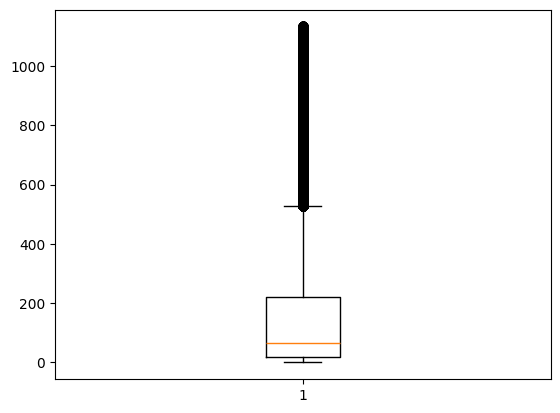

In [16]:
plt.boxplot(df_segm_1[nombre_columna_objetivo])

In [17]:
df_segm_1  = filtrar_por_desviacion_estandar(df_segm_1[columnas_utilizadas])
df_segm_1.shape

(8464246, 6)

{'whiskers': [<matplotlib.lines.Line2D at 0x153e1be71c0>,
 'caps': [<matplotlib.lines.Line2D at 0x153e1be7700>,
 'boxes': [<matplotlib.lines.Line2D at 0x153e1bd9ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x153e1be7c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x153e1be7ee0>],
 'means': []}

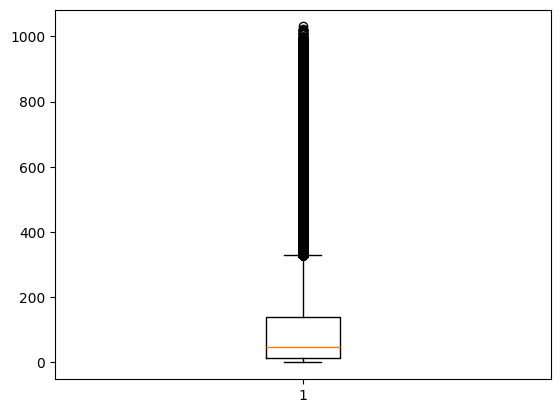

In [18]:
plt.boxplot(df_segm_1[nombre_columna_objetivo])

In [19]:
# Dividir el conjunto de datos en características (X) y objetivo (y)
X = df_segm_1[columnas_x]
y = df_segm_1[nombre_columna_objetivo]

In [20]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f'Tamaño set de entrenamientos: X: {X_train.shape} y: {y_train.shape}')
print(f'Tamaño set de validacion: X: {X_valid.shape} y: {y_valid.shape}')
print(f'Tamaño set de prueba: X: {X_test.shape} y: {y_test.shape}')

Tamaño set de entrenamientos: X: (6771396, 2) y: (6771396,)
Tamaño set de validacion: X: (846425, 2) y: (846425,)
Tamaño set de prueba: X: (846425, 2) y: (846425,)


In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Modelos
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Support Vector Machine', SVR())
]

In [22]:
# Modelos
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Support Vector Machine', SVR())
]

Linear Regression - Mean Squared Error: 9579.398858715364


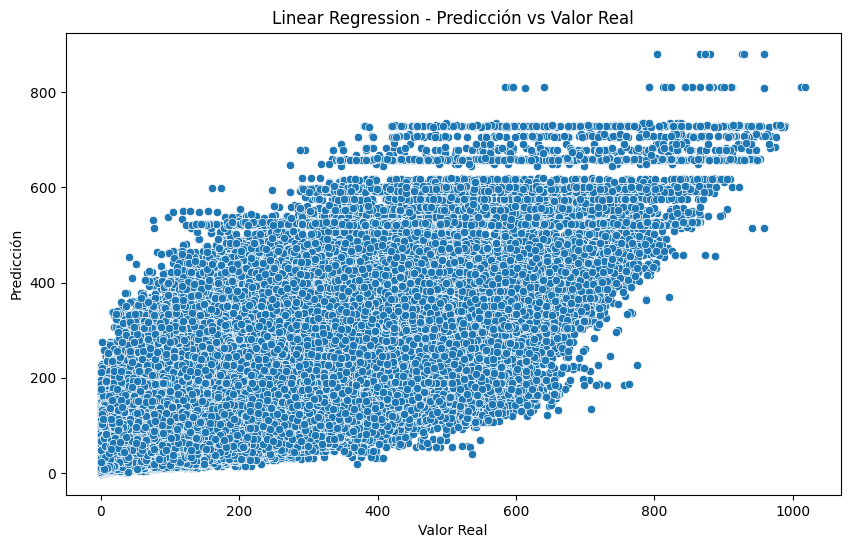

Ridge Regression - Mean Squared Error: 9579.206966805386


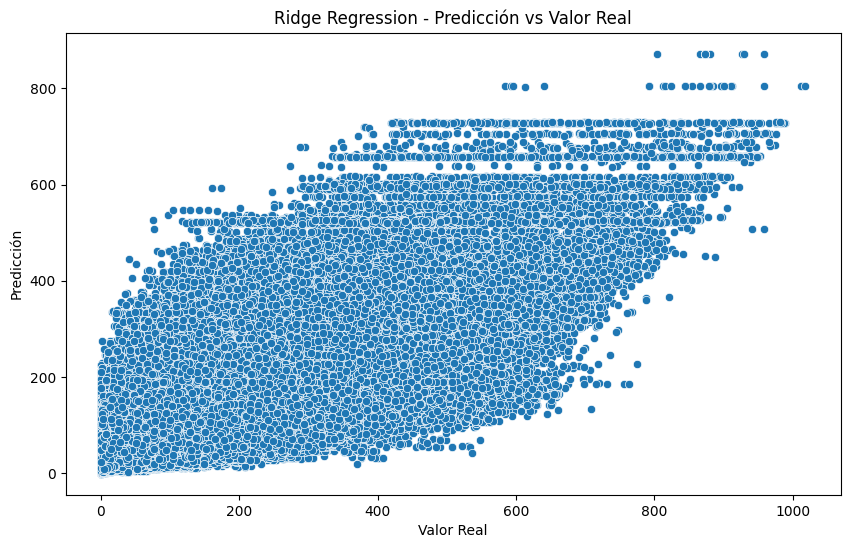

Lasso Regression - Mean Squared Error: 16610.63730032667


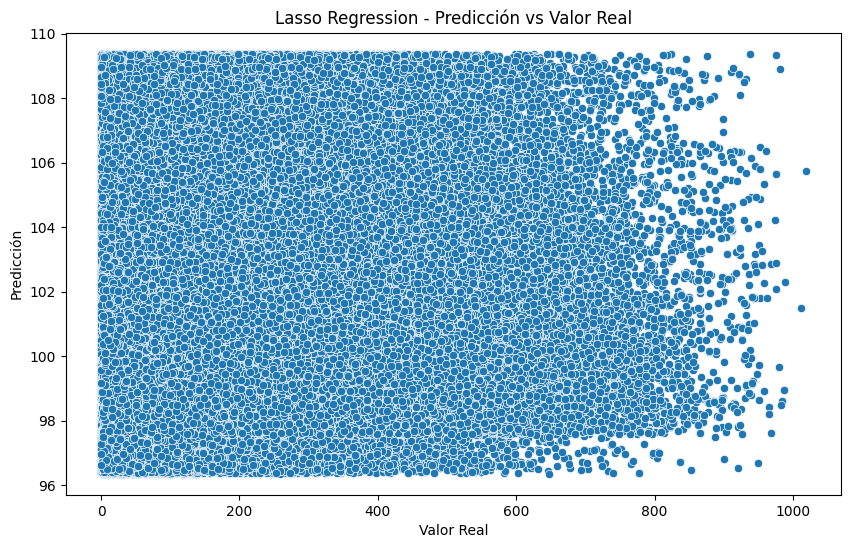

Decision Tree - Mean Squared Error: 12637.187296898173


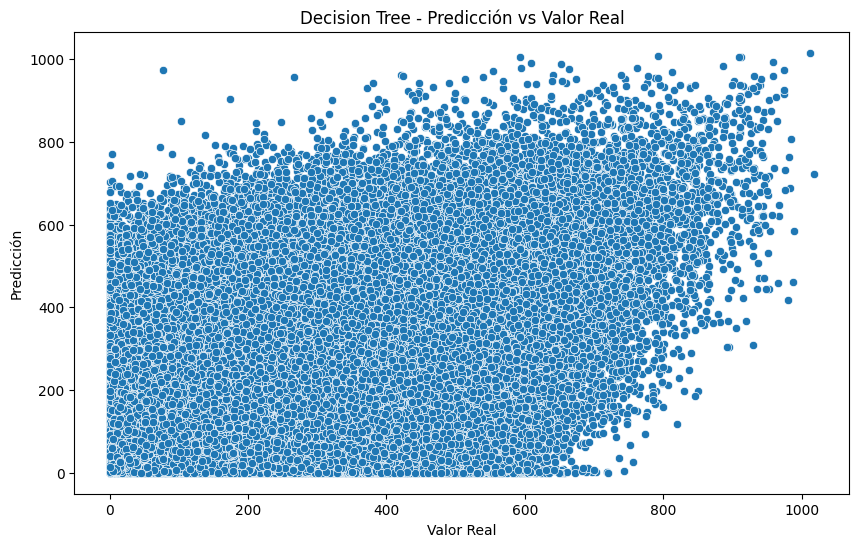

In [23]:
# Probar modelos
for model_name, model in models:
    # Crear un pipeline con el preprocesamiento y el modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)
    
    # Calcular el Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    
    # Mostrar los resultados
    print(f'{model_name} - Mean Squared Error: {mse}')

    # Visualizar la predicción vs el valor real
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.title(f'{model_name} - Predicción vs Valor Real')
    plt.show()

In [ ]:
# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
df_train_scaled = pd.DataFrame(X_train_scaled, columns=[X_train.columns])
df_train_scaled.head()

In [ ]:
# Entrenar modelos y evaluar rendimiento
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Support Vector Machine', SVR())
]

In [ ]:
for model_name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{model_name} - Mean Squared Error: {mse}')

    # Visualizar la predicción vs el valor real
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.title(f'{model_name} - Predicción vs Valor Real')
    plt.show()

In [ ]:
# Predecir para fechas futuras
# Puedes crear un conjunto de datos con fechas futuras y productos correspondientes
# Luego normalizar esos datos y usar el modelo entrenado para hacer predicciones
# Por ejemplo, si deseas predecir para el próximo mes:
from datetime import datetime, timedelta

In [ ]:
next_month_date = datetime.now() + timedelta(days=30)
next_month_data = pd.DataFrame({
    'fecha': [next_month_date] * len(df['id_producto'].unique()),  # para cada producto
    'id_producto': df['id_producto'].unique()
})

In [ ]:
# Normalizar los datos para predecir
next_month_data_scaled = scaler.transform(next_month_data)

# Hacer predicciones con el modelo seleccionado (por ejemplo, RandomForestRegressor)
predictions = model.predict(next_month_data_scaled)

# Las predicciones estarán en la escala original de 'monto_adjudicado_usd'
print(predictions)
